# Digit Recognizer

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import graphviz
import keras_cv
import plotly.express as px
import plotly.graph_objects as go


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,LeakyReLU,ReLU,Flatten,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu,sigmoid,softmax
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

## Import the Digit Recognizer dataset by the MNIST

The data files *train.csv* and *test.csv* contain gray-scale images of hand-drawn digits, from zero through nine.\
[Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer/data) datasets are shared by the MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

In [5]:
digit_recognizer_train = pd.read_csv('train.csv')
digit_recognizer_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Exploration

**Check the shape of the data**

In [6]:
digit_recognizer_train.shape

(42000, 785)

Let's explore the format of the dataset before training the model. The training dataset includes 42,000 images. Each image represented as 28 x 28 pixels.

**Check for data types**

In [7]:
digit_recognizer_train.dtypes

label       int64
pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 785, dtype: object

**Check for missing values**

In [8]:
digit_recognizer_train.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

## Preprocess the Data

In [9]:
digit_recognizer_train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [10]:
target = digit_recognizer_train["label"] 
target.nunique()

10

In [11]:
features = digit_recognizer_train.drop(columns= ["label"]) 
features

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Visualise the first image in the training set
# Extract the first row of pixel values and reshape to 28x28
first_digit_pixels = features.iloc[0, 0:].values.reshape(28, 28)

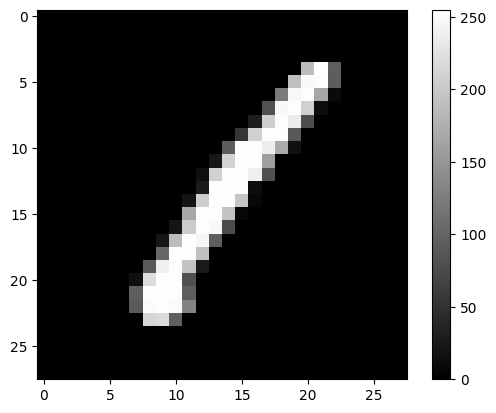

In [13]:
# Plot the image
plt.figure()
plt.imshow(first_digit_pixels, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### Normalising

The data must be preprocessed before training the network. In order to inspect the first image in the training set, let's transform the pixel values fall in the range of 0 to 255:

In [14]:
features = features / 255.0

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, dividing the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [15]:
# Define the class names (digits in this case)
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
type(digits[0])

int

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the training set and display the class name below each image.

In [16]:
# Reshape and Display the first 25 images from the training set with their labels
for i in range(25):
    # Extract the image data and label 
    image_data = features.iloc[i, 0:].values.reshape(28, 28) 
    label = target[i]
    print(label)

1
0
1
4
0
0
7
3
5
3
8
9
1
3
3
1
2
0
7
5
8
6
2
0
2


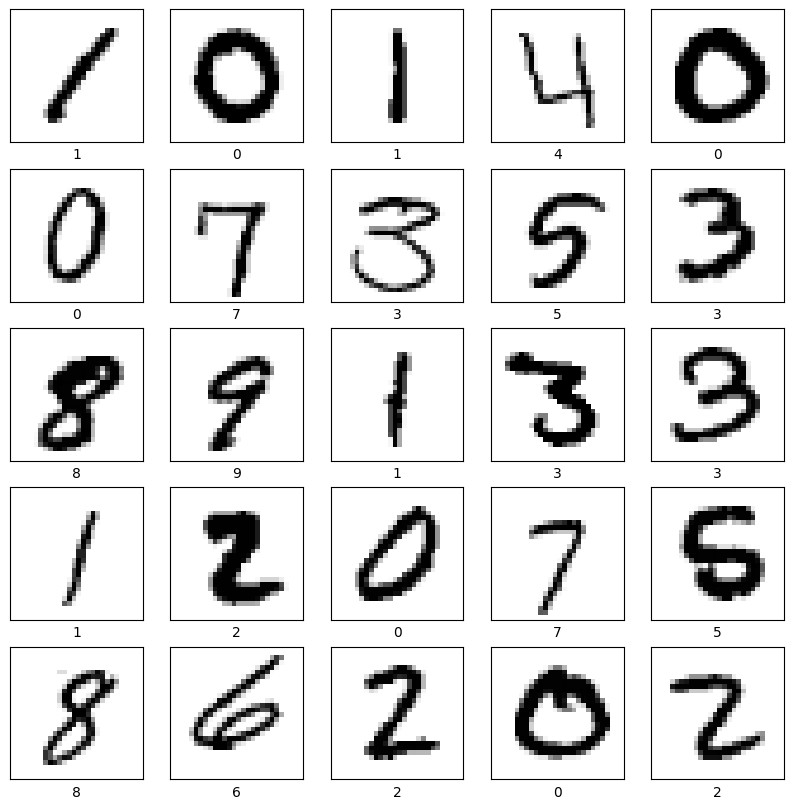

In [17]:
# Reshape and Display the first 25 images from the training set with their labels
plt.figure(figsize=(10,10))
for i in range(25):
    # Extract the image data and label 
    image_data = features.iloc[i, 0:].values.reshape(28, 28) 
    label = target[i]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_data, cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()

### Train and Test Split

Now we perform the division between Train and Test, we will reserve 20% of our data to Test.

In [18]:
# X refers to features data
# Y refers to target
# 20% to test after the training  
train_images, test_images, train_labels, test_labels = train_test_split(features, target, test_size=0.20, random_state=0) 

## Build the Model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The MNIST dataset consists of grayscale images of handwritten digits (0-9). The task involves identifying the digit in each image, which is a classification problem.\
`ReLU` helps in creating a deeper network with more complex features without running into issues like vanishing gradients, leading to better performance in identifying the digits accurately.

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'), # First Dense layer has 128 nodes (or neurons): standard in ML models
    tf.keras.layers.Dense(10) # Logits array with length of 10, as output goes from 0 to 9.
])

When the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a `score that indicates the current image belongs to one of the 10 classes`.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

***Optimizer*** —This is how the model is updated based on the data it sees and its loss function.\
***Loss function*** —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.\
***Metrics*** —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

`Implementing Adam`\
Efficiency: Adam converges quickly due to its adaptive learning rate and momentum-like properties.\
Flexibility: It works well with sparse gradients and is less sensitive to hyperparameter tuning.\
Robustness: It generally performs well across a wide range of problems and architectures.

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the features and target arrays.
2. The model learns to associate images and labels.
3. Then, asking the model to make predictions about a test set—in this example, the digit_recognizer_test array.
4. Verify that the predictions match the labels from the digit_recognizer_test array.

### Feed the model

To start training, call the model.fit method—so called because it "fits" the model to the training data:

Epoch : An epoch refers to one complete cycle through the entire training dataset. After an epoch, the model has seen each training sample exactly once.

model.fit(train_images, train_labels, epochs=10), the epochs=10 means that the model will go through the entire training dataset 10 times. The choice of 10 epochs is somewhat arbitrary and can vary depending on the problem, the dataset size, and other factors. It’s often determined through experimentation, where you might start with a certain number of epochs and adjust based on the model’s performance on a validation dataset.

In [22]:
model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))
# accuracy is based on training data
# val_accuracy is evaluating the test data

Epoch 1/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8430 - loss: 0.5498 - val_accuracy: 0.9452 - val_loss: 0.1923
Epoch 2/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9552 - loss: 0.1558 - val_accuracy: 0.9611 - val_loss: 0.1467
Epoch 3/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9697 - loss: 0.1041 - val_accuracy: 0.9660 - val_loss: 0.1214
Epoch 4/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9780 - loss: 0.0778 - val_accuracy: 0.9702 - val_loss: 0.1134
Epoch 5/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9840 - loss: 0.0551 - val_accuracy: 0.9686 - val_loss: 0.1149
Epoch 6/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9860 - loss: 0.0448 - val_accuracy: 0.9667 - val_loss: 0.1101
Epoch 7/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9924 - loss: 0.0295 - val_accuracy: 0.9679 - val_loss: 0.1179
Epoch 8/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9924 - loss: 0.0252 - 

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.99 (or 99%) on the training data.

### Evaluate accuracy

In [23]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

263/263 - 0s - 1ms/step - accuracy: 0.9746 - loss: 0.0951

Test accuracy: 0.9746428728103638


### Make predictions

In [24]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [25]:
predictions = probability_model.predict(test_images)

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [26]:
predictions[0]

array([6.4786515e-10, 1.6551129e-10, 2.6460160e-08, 9.9936932e-01,
       3.4648906e-13, 6.0659506e-05, 1.5218362e-13, 2.9143684e-11,
       1.2310941e-04, 4.4691999e-04], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different digits. 

In [27]:
# Find the index of the highest probability
predicted_digit = np.argmax(predictions[0])

# Create a one-hot encoded array
one_hot_encoded = np.zeros_like(predictions[0])
one_hot_encoded[predicted_digit] = 1

print(one_hot_encoded)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Here notice that the label has the highest confidence value:

In [28]:
np.argmax(predictions[0])

3

So, the model is most confident that this image is an digit 3. Examining the test label shows that this classification is correct:

In [29]:
test_labels.values[0]

3

Here the functions to graph the full set of 10 digits predictions:

In [30]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label.iloc[i], img.iloc[i].values.reshape(28, 28) 
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(digits[predicted_label],
                                100*np.max(predictions_array),
                                digits[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label.iloc[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

Let's look at the 10th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

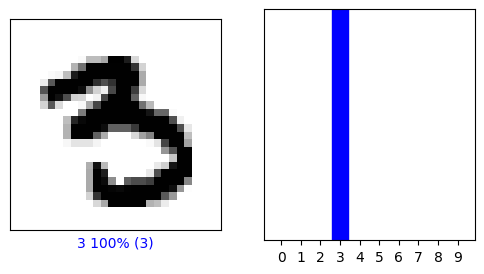

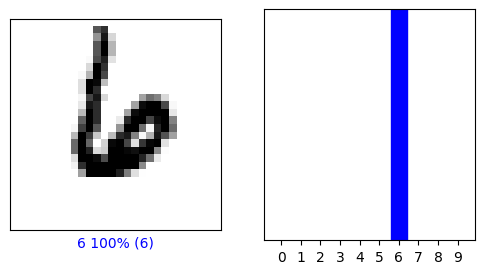

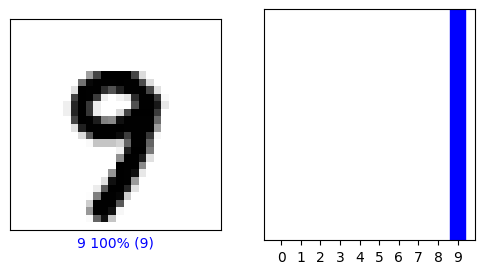

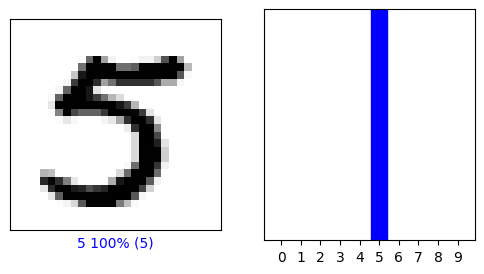

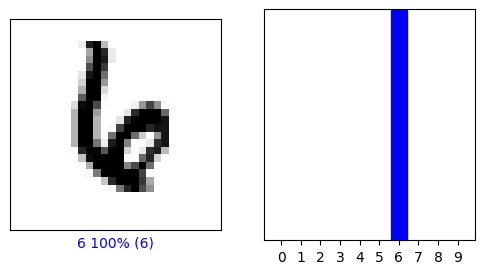

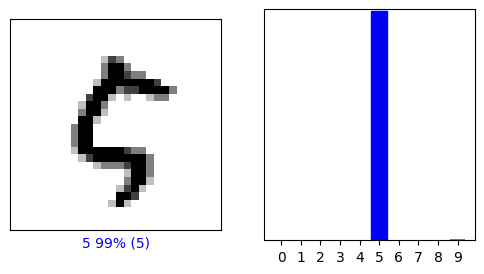

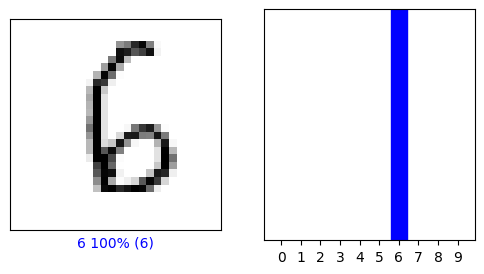

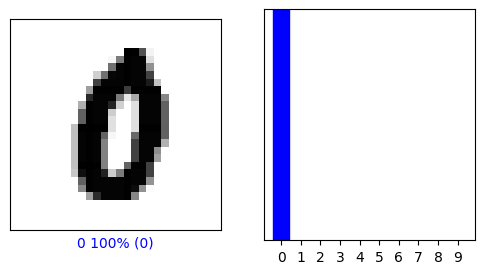

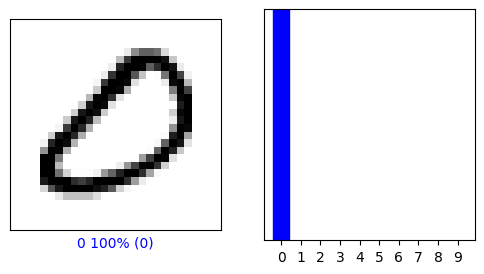

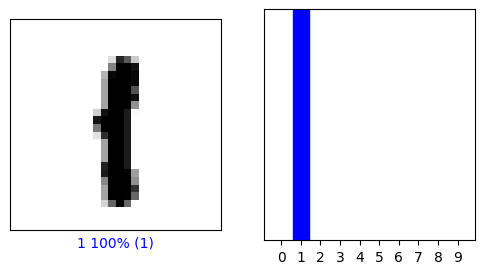

In [31]:
for i in range(10):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(1,2,2)
    plot_value_array(i, predictions[i],  test_labels)
    plt.show()

## Use the trained model

To conclude, let's use the trained model to make a prediction about a single image.

In [32]:
digit_recognizer_test = pd.read_csv('test.csv')
digit_recognizer_test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Visualise the first image in the training set
# Extract the first row of pixel values and reshape to 28x28
img_test = digit_recognizer_test.iloc[0, 0:].values.reshape(28, 28)

In [34]:
img_test.shape

(28, 28)

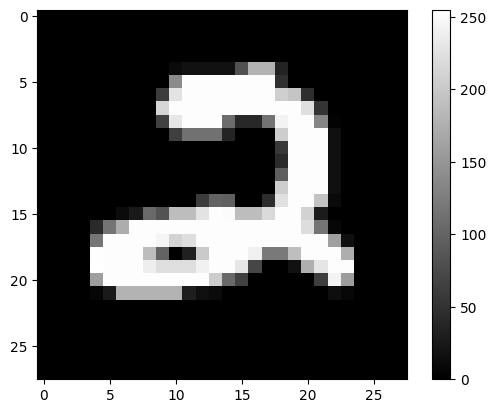

In [35]:
# Plot the image
plt.figure()
plt.imshow(img_test, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

In [36]:
img_test = digit_recognizer_test.iloc[0, 0:]
img_test

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Name: 0, Length: 784, dtype: int64

In [37]:
# Add the image to a batch where it's the only member.
img_test = (np.expand_dims(img_test,0))

print(img_test.shape)

(1, 784)


In [38]:
single_prediction = probability_model.predict(img_test)

single_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [39]:
full_prediction = probability_model.predict(digit_recognizer_test)
score = tf.nn.softmax(full_prediction[0])

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [40]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(digits[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 2 with a 23.20 percent confidence.


#### Advanced modeling: Adding Conv2D and MaxPool layers to the keras model:

In [82]:
model_adv = tf.keras.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)), 
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),  # Dense layer with 128 neurons
    tf.keras.layers.Dense(10)  # Output layer with 10 neurons (for 10 classes)
])

/Volumes/MacintoshHD/Users/veronicalarroy/Desktop/anaconda3/envs/IH_BCN_DAFT/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [83]:
model_adv.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy', 'mse'])

In [84]:
model_adv.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,922 (808.29 KB)

 Trainable params: 206,922 (808.29 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
model_adv.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.8657 - loss: 0.4473 - mse: 49.8034 - val_accuracy: 0.9762 - val_loss: 0.0824 - val_mse: 67.6120
Epoch 2/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9797 - loss: 0.0652 - mse: 70.2025 - val_accuracy: 0.9836 - val_loss: 0.0549 - val_mse: 71.0148
Epoch 3/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9875 - loss: 0.0395 - mse: 76.8185 - val_accuracy: 0.9876 - val_loss: 0.0466 - val_mse: 72.3647
Epoch 4/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9924 - loss: 0.0257 - mse: 87.0667 - val_accuracy: 0.9868 - val_loss: 0.0496 - val_mse: 86.6762
Epoch 5/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9939 - loss: 0.0199 - mse: 100.2053 - val_accuracy: 0.9895 - val_loss: 0.0421 - val_mse: 115.1961
Epoch 6/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9956 - loss: 0.0132 - mse: 121.1421 - val_accuracy: 0.9844 - val_loss: 0.0511 - val_mse: 111.1411


In [86]:
predictions = model_adv.predict(digit_recognizer_test)
score = tf.nn.softmax(predictions[0])

875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


In [87]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(digits[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 2 with a 100.00 percent confidence.


In [53]:
predictions = model_adv.predict(df)

875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


In [54]:
pred = predictions.argmax(axis=1)

#### Advanced modeling: DecisionTree! :)

In [48]:
tree = DecisionTreeClassifier(max_depth=10)

In [49]:
tree.fit(train_images, train_labels)

DecisionTreeClassifier(max_depth=10)

In [50]:
pred = tree.predict(test_images) #metricas de classification report 
tree_mean_accuracy = tree.score(test_images, test_labels)
tree_mean_accuracy

0.8459523809523809

In [51]:
pred

array([3, 6, 9, ..., 8, 7, 2])

In [52]:
df = pd.read_csv("test.csv")
df = df / 255.0 # APPLY THE TRANSFORMATIONS FROM TRAIN TO TEST ALSO !!!!!!!
pred = tree.predict(df)

In [55]:
len(pred)

28000

In [56]:
results = pd.Series(pred,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submision.csv", index=False)



In [57]:
dot_data = export_graphviz(tree, out_file="tree.dot", filled=True, rounded=True, feature_names=train_images.columns)

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

#### Advanced modeling: RandomForest

In [59]:
forest = RandomForestClassifier(n_estimators=100,
                             max_depth=20)

In [60]:
forest.fit(train_images, train_labels)

RandomForestClassifier(max_depth=20)

In [61]:
pred = forest.predict(test_images)

forest_mean_accuracy = forest.score(test_images, test_labels)
forest_mean_accuracy

0.9642857142857143

In [ ]:
grid = {"n_estimators": [50, 100, 150],
        "estimator__max_leaf_nodes": [250],
        "estimator__max_depth":[10,15, 20]}

In [ ]:
ada_reg = AdaBoostClassifier(DecisionTreeClassifier())
model = RandomizedSearchCV(estimator = ada_reg, param_distributions = grid, cv = 5, n_jobs = -1)

In [ ]:
#model.fit(train_images, train_labels)

#### Plotting the accuracies of our models: 2-layer NN, 8-layer NN, DecisionTree, and RandomForest

In [81]:
#first we need to extract the accuracies for the 2 and 8-layer models. We need the highest val_accuracy for both, corresponding to 10th epoch.
two_lyer_mean_acc = 0.9724
eight_lyr_mean_acc = 0.9896
tree_mean_acc = 0.8467
forest_mean_acc = 0.9635

#now, put them all in a list:
grouped_acc = [two_lyer_mean_acc,
               eight_lyr_mean_acc,
               tree_mean_acc,
               forest_mean_acc
               ]

#create names for our plot:
model_names = ["2-layer NN",
               "8-layer NN",
               "DecisionTree",
               "RandomForest"]

#now we have all we need to plot!
fig = px.bar(x=model_names, y=grouped_acc)
fig.show()

#### Testing our model with hand-written numbers from our bootcamp colleagues and teachers

In [ ]:
# Load and preprocess the image
#image = load_img('path_to_image.jpg', color_mode='grayscale')
#image_array = img_to_array(image)

In [140]:
# List of image paths
images = [
    '00.jpg',
    '01.jpg',
    '02.jpg',
    '03.jpg',
    '04.jpg',
    '05.jpg',
    '06.jpg',
    '07.jpg',
    '08.jpg',
    '09.jpg'
]

# Initialize an empty list to store flattened images
flattened_images = []

# Loop through each image 
for i in images:
    # Load the image in grayscale
    image = load_img(i, color_mode='grayscale')
    # Convert to array and normalize
    image_array = img_to_array(image) / 255.0
    # Resize the image to 28x28
    image_resized = tf.image.resize(image_array, (28, 28))
    # Invert colors if necessary
    image_inverted = 1 - image_resized
    # Convert EagerTensor to NumPy array
    image_numpy = image_inverted.numpy()
    # Flatten the image to a 1D array of 784 pixels
    image_mask = np.where(image_numpy < 0.4,0, image_numpy)
    flattened_image = image_mask.flatten()
    # Append the flattened image to the list
    flattened_images.append(flattened_image)

In [143]:
tatiana = pd.DataFrame(flattened_images)
pd.set_option('display.max_columns',None)
tatiana.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0

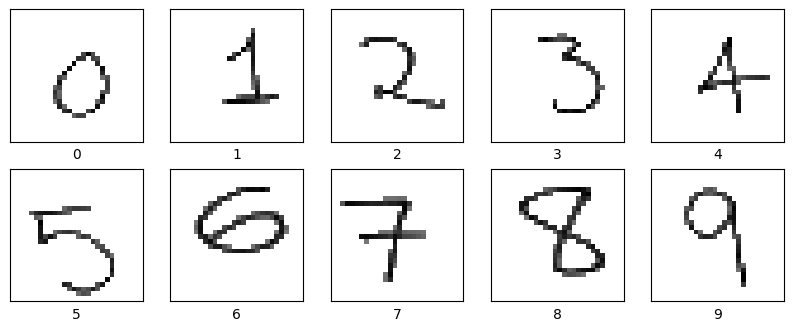

In [144]:
# Reshape and Display the first 25 images from the training set with their labels
plt.figure(figsize=(10,10))
for i in range(10):
    # Extract the image data and label 
    image_data = tatiana.iloc[i, 0:].values.reshape(28, 28) 
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_data, cmap=plt.cm.binary)
    plt.xlabel(i)
plt.show()

In [145]:
tatiana_predictions = model_adv.predict(tatiana)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [146]:
# Get the predicted classes (digits)
predicted_classes = np.argmax(tatiana_predictions, axis=1)

# Display the results
for i, prediction in enumerate(predicted_classes):
    print(f"Image {i}: Predicted digit is {prediction}")


Image 0: Predicted digit is 0
Image 1: Predicted digit is 4
Image 2: Predicted digit is 2
Image 3: Predicted digit is 0
Image 4: Predicted digit is 4
Image 5: Predicted digit is 5
Image 6: Predicted digit is 6
Image 7: Predicted digit is 7
Image 8: Predicted digit is 8
Image 9: Predicted digit is 9


In [147]:
def adv_model_pred(images_: list) ->str:
    flattened_images = []

    # Loop through each image 
    for i in images:
        # Load the image in grayscale
        image = load_img(i, color_mode='grayscale')
        # Convert to array and normalize
        image_array = img_to_array(image) / 255.0
        # Resize the image to 28x28
        image_resized = tf.image.resize(image_array, (28, 28))
        # Invert colors if necessary
        image_inverted = 1 - image_resized
        # Convert EagerTensor to NumPy array
        image_numpy = image_inverted.numpy()
        # Flatten the image to a 1D array of 784 pixels
        image_mask = np.where(image_numpy < 0.4,0, image_numpy)
        flattened_image = image_mask.flatten()
        # Append the flattened image to the list
        flattened_images.append(flattened_image)
        

    df = pd.DataFrame(flattened_images)

    plt.figure(figsize=(10,10))
    for i in range(10):
        # Extract the image data and label 
        image_data = df.iloc[i, 0:].values.reshape(28, 28) 
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_data, cmap=plt.cm.binary)
        plt.xlabel(i)
    plt.show()

    pred = model_adv.predict(df)
    pred_array = np.argmax(pred, axis=1)
    
    results = []
    for i, prediction in enumerate(pred_array):
        results.append(f"Image {i}: Predicted digit is {prediction}")
    
    return print("\n".join(results))
        
    

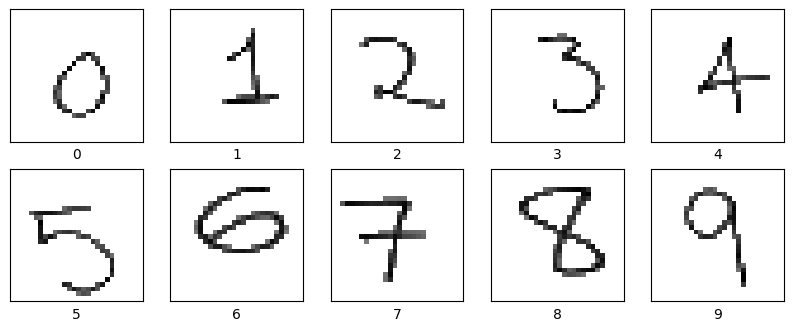

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image 0: Predicted digit is 0
Image 1: Predicted digit is 4
Image 2: Predicted digit is 2
Image 3: Predicted digit is 0
Image 4: Predicted digit is 4
Image 5: Predicted digit is 5
Image 6: Predicted digit is 6
Image 7: Predicted digit is 7
Image 8: Predicted digit is 8
Image 9: Predicted digit is 9


In [148]:
miki_images = [
    '10.jpeg',
    '11.jpeg',
    '12.jpeg',
    '13.jpeg',
    '14.jpeg',
    '15.jpeg',
    '16.jpeg',
    '17.jpeg',
    '18.jpeg',
    '19.jpeg'
]

adv_model_pred(miki_images)

In [ ]:
def plot_image_pred(i, predictions_array, img):
  img = true_label.iloc[i], img.iloc[i].values.reshape(28, 28) 
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(digits[predicted_label],
                                100*np.max(predictions_array),
                                digits[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label.iloc[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')